# Linear regression with Eustatic Sea-level data

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_sealevel.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we demonstrate use of CoFI on a real dataset **linear regression** problem, where we fit a polynomial function to Eustatic Sea-level heights.

- by solution of a linear system of equations,
- by optimization of a data misfit function
- by Bayesian sampling of a Likelihood multiplied by a prior.

---

Data set is from "Sea level and global ice volumes from the Last Glacial Maximum to the Holocene"
K. Lambeck, H. Rouby, A. Purcell, Y. Sun, and M. Sambridge, 2014. 
Proc. Nat. Acad. Sci., 111, no. 43, 15296-15303, doi:10.1073/pnas.1411762111.

In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi

Remember to uncomment and run the code cell below as well, as we are going to
load some data from GitHub.

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/linear_regression

## Linear regression

Lets start with some (x,y) data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#
def load_data_xy(filename):

    f = open(filename, 'r')
    header = f.readline()
    lines = f.readlines()

    x = np.array([])
    y = np.array([])
    sx = np.array([])
    sy = np.array([])
    for line in lines:
        columns = line.split()
        x = np.append(x,float(columns[0]))
        y = np.append(y,float(columns[1]))
        sx = np.append(sx,float(columns[2])/2.0)
        sy = np.append(sy,float(columns[3])/2.0)

    d = x,y, sy                                   # Combine into a single data structure

    return d

def load_data_ref(filename):

    f = open(filename, 'r')
    lines = f.readlines()
    dx = np.array([]) # Age data
    dy = np.array([]) # ESL height
    dz = np.array([]) # derivative of ESL w.r.t. age
    for line in lines:
        columns = line.split()
        dx = np.append(dx,float(columns[0]))
        dy = np.append(dy,float(columns[1]))
    datavals = np.column_stack((dx,dy))  # Stack data

    return datavals

In [5]:
data_x,data_y,sy = load_data_xy("ESL-ff11-sorted.txt")  # Load x,sx,y,sy ESL data (x=time, Y=ESL)

In [6]:
maxtime = 20.
ndata = np.where(data_x>maxtime)[0][0]

In [7]:
data_x,data_y,sy = data_x[:ndata],data_y[:ndata],sy[:ndata]

And now lets plot the data.

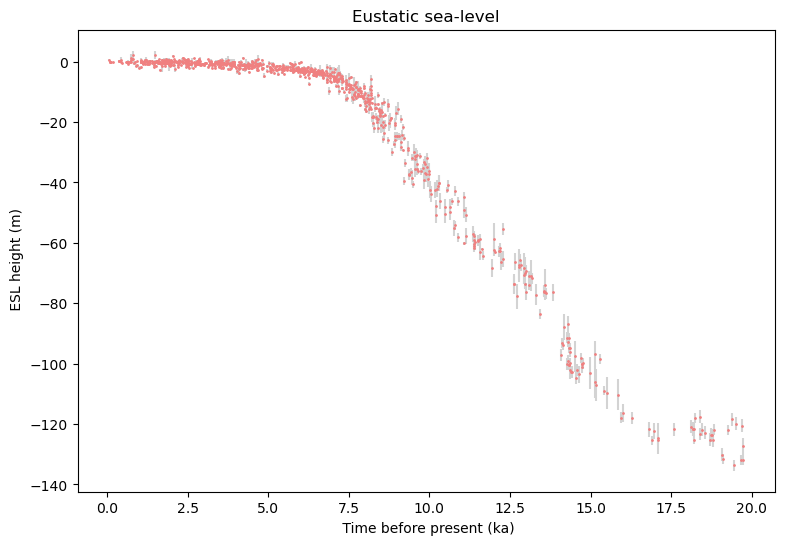

In [8]:
def plot_data(x=data_x,y=data_y,sigma=sy,title=None):
    fig, axes = plt.subplots(figsize=(9,6))
    plt.errorbar(x, y, yerr=sy, fmt='.',color="lightcoral",ecolor='lightgrey',ms=2)
    plt.xlabel(' Time before present (ka)')
    plt.ylabel(' ESL height (m)')
    if(title != None): plt.title(title)
plot_data(title='Eustatic sea-level')

## Problem description

To begin with, we will work with polynomial curves, $$y(x) = \sum_{j=0}^M m_j x^j\,.$$
Here, $M$ is the 'order' of the polynomial: if $M=1$ we have a straight line with 2 parameters, if $M=2$ it will be a quadratic with 3 parameters, and so on. The $m_j, (j=0,\dots M)$ are the 'model coefficients' that we seek to constrain from the data.

For this class of problem the forward operator takes the following form:

$$ \left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$


This clearly has the required general form, $\mathbf{d} =G{\mathbf m}$.

where:

- $\textbf{d}$ is the vector of data values, ($y_0,y_1,\dots,y_N$);
- $\textbf{m}$ is the vector of model parameters, ($m_0,m_1,m_2$);
- $G$ is the basis matrix (or design matrix) of this linear regression problem (also called the ***Jacobian*** matrix for this linear problem).



We have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The function that generated our data is assumed to have independent Gaussian random noise, ${\cal N}(0,\Sigma)$, with $(\Sigma)_{ij} = \delta_{ij}/\sigma_i^2$, where the variance of the noise on each datum, $\sigma_i^2 (i=1,\dots,N)$, differs between observations and is given.

We now build the Jacobian/G matrix for this problem and define a forward function which simply multiplies $\mathbf m$ by $G$.

In [9]:
nparams = 5 # Number of model parameters to be solved for

def jacobian(x=data_x, n=nparams):
    return np.array([x**i for i in range(n)]).T

def forward(model):
    return jacobian().dot(model)

def Cd_inv(sigma=sy):
    factor= 10                                   # factor to inflate observational errors
    return np.diag(1./sy*1./sy)/(factor**2)

Define a reference model for later.

In [10]:
# Reference model for plotting
ESLref = load_data_ref("ESL-f11_yonly.txt") # Load x, y, z reference model and estimated derivative (x=time, Y=ESL, z=dESL/dt) 
ndata2 = np.where(ESLref.T[0]>maxtime)[0][0]
ESLref = ESLref[:ndata2]
ref_x,ref_y = ESLref.T[0],ESLref.T[1]

Now lets plot the data with the reference curve

In [11]:
# Some plotting utilities
def plot_model(x,y, label, color=None,lw=0.5):
    plt.plot(x, y, color=color or "green", label=label,lw=lw)
    #plt.xlabel("X")
    #plt.ylabel("ESL")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1,lw=0.5):
    G = jacobian(data_x)
    plt.plot(data_x, G.dot(models[0]), color=color, label=label, alpha=alpha,lw=lw)
    for m in models:
        plt.plot(data_x, G.dot(m), color=color, alpha=alpha,lw=lw)
    plt.legend()

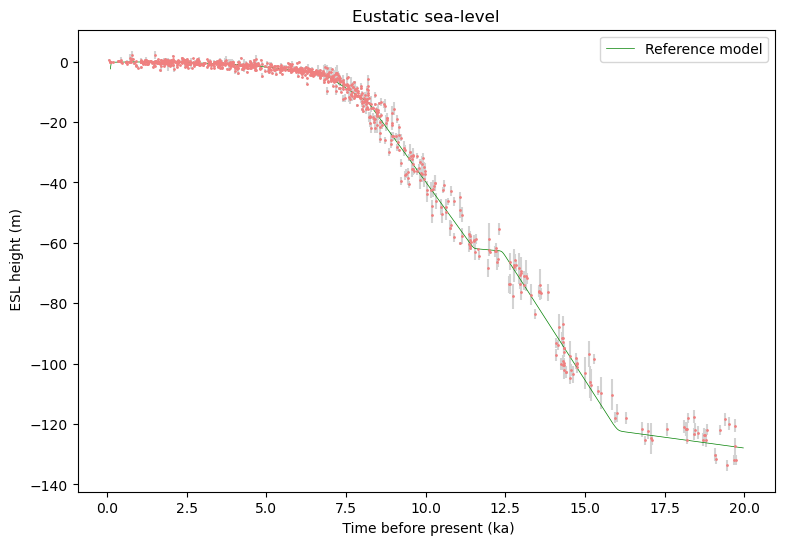

In [12]:
plot_data(title="Eustatic sea-level")
plot_model(ref_x,ref_y, "Reference model")

Now we have the data and the forward model we can start to try and estimate the coefficients of the polynomial from the data.

## The structure of CoFI <a name="CoFI-structure"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines the inverse problem including any user supplied quantities such as data vector, number of model parameters and measure of fit between model predictions and data. 
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_jacobian(some_function_here)
    inv_problem.set_initial_model(a_starting_point) # if needed, e.g. we are solving a nonlinear problem by optimization
    ```
    
    &nbsp; 
- `InversionOptions` describes details about how one wants to run the inversion, including the backend tool and solver-specific parameters. It is based on the concept of a `method` and `tool`.

    ```python
    inv_options = InversionOptions()
    inv_options.suggest_solving_methods()
    inv_options.set_solving_method("matrix solvers")
    inv_options.suggest_tools()
    inv_options.set_tool("scipy.linalg.lstsq")
    inv_options.summary()
    ```

    &nbsp; 
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
    ```python
    inv = Inversion(inv_problem, inv_options)
    result = inv.run()
    ```
 
 Internally CoFI decides the nature of the problem from the quantities set by the user and performs internal checks to ensure it has all that it needs to solve a problem.

## 1. Linear system solver

In [13]:
from cofi import BaseProblem, InversionOptions, Inversion

### Step 1. Define CoFI `BaseProblem`

In [14]:
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian())
inv_problem.set_data_covariance_inv(Cd_inv())

### Step 2. Define CoFI `InversionOptions`

In [15]:
inv_options = InversionOptions()

Using the information supplied, we can ask CoFI to suggest some solving methods.

In [16]:
inv_options.suggest_solving_methods()

The following solving methods are supported:
{'optimization', 'sampling', 'matrix solvers'}

Use `suggest_tools()` to see a full list of backend tools for each method


We can ask CoFI to suggest some specific software tools as well. 

In [17]:
inv_options.suggest_tools()

Here's a complete list of inversion solvers supported by CoFI (grouped by methods):
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim"
    ],
    "matrix solvers": [
        "scipy.linalg.lstsq",
        "cofi.simple_newton"
    ],
    "sampling": [
        "emcee"
    ]
}


In [18]:
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.linalg.lstsq (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [19]:
# below is optional, as this has already been the default tool under "linear least square"
inv_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

Our choices so far have defined a linear parameter estimation problem (without any regularization) to be solved within a least squares framework. In this case 
the selection of a `matrix solvers` method will mean we are calculating the standard least squares solution 

$$
m = (G^T C_d^{-1} G)^{-1} G^T C_d^{-1} d
$$

and our choice of backend tool `scipy.linalg.lstsq`, means that we will employ scipy's `linalg` package to perform the numerics.

Lets run CoFI.

In [20]:
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

In [21]:
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]

Summary for inversion result
SUCCESS
----------------------------
model: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]
sum_of_squared_residuals: []
effective_rank: 5
singular_values: [1.72339368e+09 1.35569994e+06 3.54123758e+03 1.10384400e+02
 7.16903392e+00]
model_covariance: [[ 6.70145209e-02 -6.28173834e-02  1.67266578e-02 -1.60867740e-03
   4.77025592e-05]
 [-6.28173834e-02  7.43365995e-02 -2.23488563e-02  2.32179303e-03
  -7.20214235e-05]
 [ 1.67266578e-02 -2.23488563e-02  7.38371078e-03 -8.20763652e-04
   2.65025504e-05]
 [-1.60867740e-03  2.32179303e-03 -8.20763652e-04  9.62437921e-05
  -3.21300646e-06]
 [ 4.77025592e-05 -7.20214235e-05  2.65025504e-05 -3.21300646e-06
   1.10114955e-07]]


Lets plot the solution.

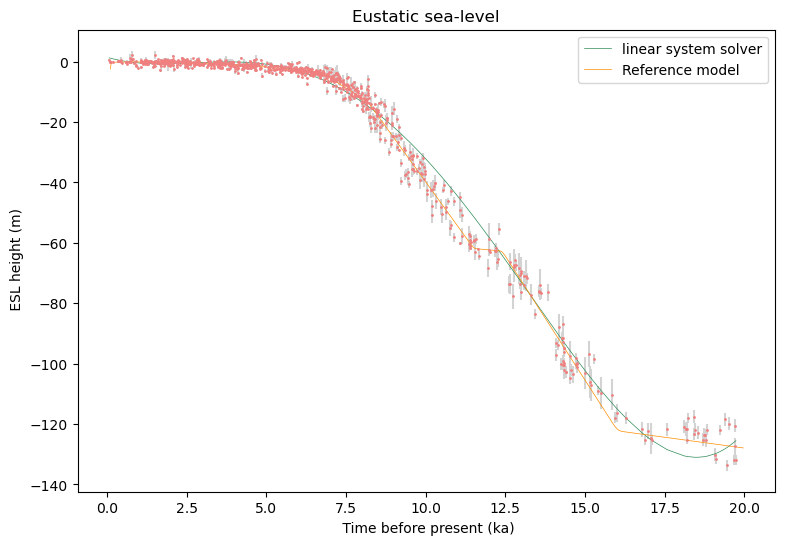

In [22]:
plot_data(title="Eustatic sea-level")
plot_model(data_x,jacobian(data_x).dot(inv_result.model), "linear system solver", color="seagreen")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

## 2. Optimizer

The same overdetermined linear problem, $\textbf{d} = G\textbf{m}$, with Gaussian data noise can also be solved by minimising the squares of the 
residual of the linear equations, e.g. $\textbf{r}^T \textbf{C}_d^{-1}\textbf{r}$ where 
$\textbf{r}=\textbf{d}-G\textbf{m}$. The above matrix solver solution gives us the best data fitting model, but a direct optimisation approach could also be used, say when the number of unknowns is large and we do not wish, or are unable to provide the Jacobian function.

So we use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

<!-- For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with 
CoFI. In the example below we provide functions to calculate the data and the optional 
regularisation. CoFI then generates the objective function for us based on the information 
provided. The alternative to this would be to directly provide objective function to CoFI. -->

In [23]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_initial_model(np.ones(nparams))
#inv_problem.set_initial_model(inv_result.model)
inv_problem.set_forward(forward)
inv_problem.set_data_misfit("squared error")

# inv_problem.set_objective(your_own_misfit_function)    # (optionally) if you'd like to define your own misfit
# inv_problem.set_gradient(your_own_gradient_of_misfit_function)    # (optionally) if you'd like to define your own misfit gradient

######## CoFI InversionOptions - set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")
inv_options_2.set_params(method="Nelder-Mead")

######## CoFI Inversion - run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]

Summary for inversion result
FAILURE
----------------------------
fun: 396.30180936007037
nit: 598
nfev: 1000
status: 1
message: Maximum number of function evaluations has been exceeded.
final_simplex: (array([[ 4.02211771, -7.6352002 ,  3.47983694, -0.52237961,  0.02043681],
       [ 4.02227491, -7.63498804,  3.47977907, -0.52238912,  0.02043829],
       [ 4.02218792, -7.63507241,  3.47979137, -0.5223722 ,  0.02043577],
       [ 4.02245903, -7.63488993,  3.47966829, -0.52235893,  0.02043602],
       [ 4.02257488, -7.63525136,  3.47962954, -0.52233062,  0.02043424],
       [ 4.02215782, -7.63502984,  3.47981924, -0.5223883 ,  0.02043736]]), array([396.30180936, 396.30181593, 396.30181983, 396.30182837,
       396.30183836, 396.30184074]))
model: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]


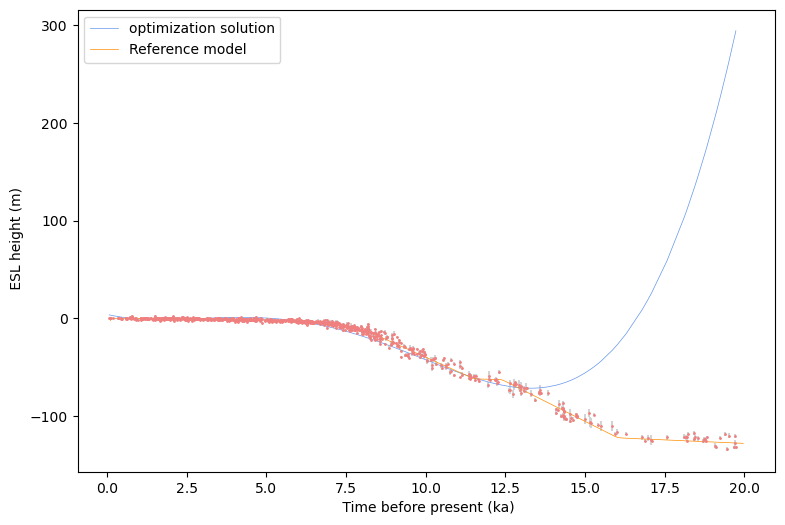

In [24]:
plot_data()
plot_model(data_x,jacobian(data_x).dot(inv_result_2.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

The optimization fails to convergence for this problem (with default settings). 

-------

### Challenge - Change the polynomial degree

Try and replace the 3rd order polynomial with a 2nd order polynomial (i.e. $M=2$) by adding the required commands below. What does the plot looks like? 

Start from code below:

```
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=<CHANGE ME>))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = <CHANGE ME> ")
plot_data()
plot_model(data_x,jacobian(x,n=<CHANGE ME>).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

```


In [25]:
# Copy the template above, Replace <CHANGE ME> with your answer



Inferred curve with n = 3 


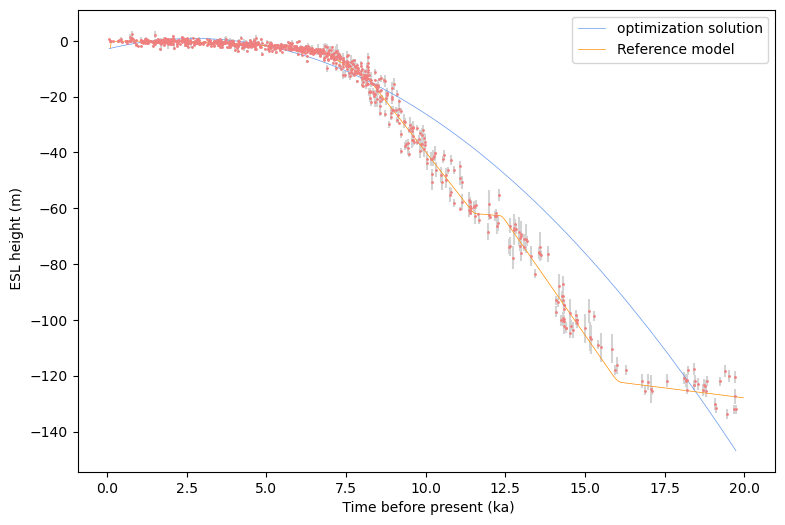

In [26]:
#@title Solution

inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=3))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = 3 ")
plot_data()
plot_model(data_x,jacobian(data_x,n=3).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

Changing to a second order polynomial does converge but gives a poor fit.

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$. 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

Here we artificially increase the observational errors on the data so that the spread of the posterior samples are visible.

In [27]:
Cdinv = Cd_inv()                 # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

Note that the user could specify **any appropriate Likelihood function** of their choosing here.

### Prior

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [28]:
m_lower_bound = np.ones(nparams) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(nparams) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m})p(\mathbf{m})$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d})$ over model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

### Starting points for random walkers

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [29]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

### Add the information and run with CoFI

In [30]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

######## CoFI InversionOptions - get a different tool
inv_options_3 = InversionOptions()
inv_options_3.set_tool("emcee")      # Here we use to Affine Invariant McMC sampler from Goodman and Weare (2010).
inv_options_3.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True, initial_state=walkers_start)

######## CoFI Inversion - run it
inv_3 = Inversion(inv_problem, inv_options_3)
inv_result_3 = inv_3.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `emcee`:")
inv_result_3.summary()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:15<00:00, 132.85it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### Post-sampling analysis

By default the raw sampler resulting object is attached to `cofi`'s inversion result.

Optionally, you can convert that into an `arviz` data structure to have access to
a range of analysis functions. (See more details in [arviz documentation](https://python.arviz.org/en/latest/index.html)).

In [31]:
import arviz as az

labels = ["m0", "m1", "m2","m3","m4"]

sampler = inv_result_3.sampler
az_idata = az.from_emcee(sampler, var_names=labels)
# az_idata = inv_result_3.to_arviz()      # alternatively

In [32]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    m0       (chain, draw) float64 7.28e-06 7.28e-06 -1.478e-05 ... 1.293 1.293
    m1       (chain, draw) float64 1.877e-05 1.877e-05 ... -2.891 -2.891
    m2       (chain, draw) float64 1.357e-05 1.357e-05 ... 1.352 1.352
    m3       (chain, draw) float64 1.888e-05 1.888e-05 ... -0.2036 -0.2036
    m4       (chain, draw) float64 -0.0001205 -0.0001205 ... 0.006413 0.006413
Attributes:
    created_at:                 2022-12-12T03:41:13.606194
    arviz_version:              0.12.1
    inference_library:          emcee
    inference_library_version:  3.1.2

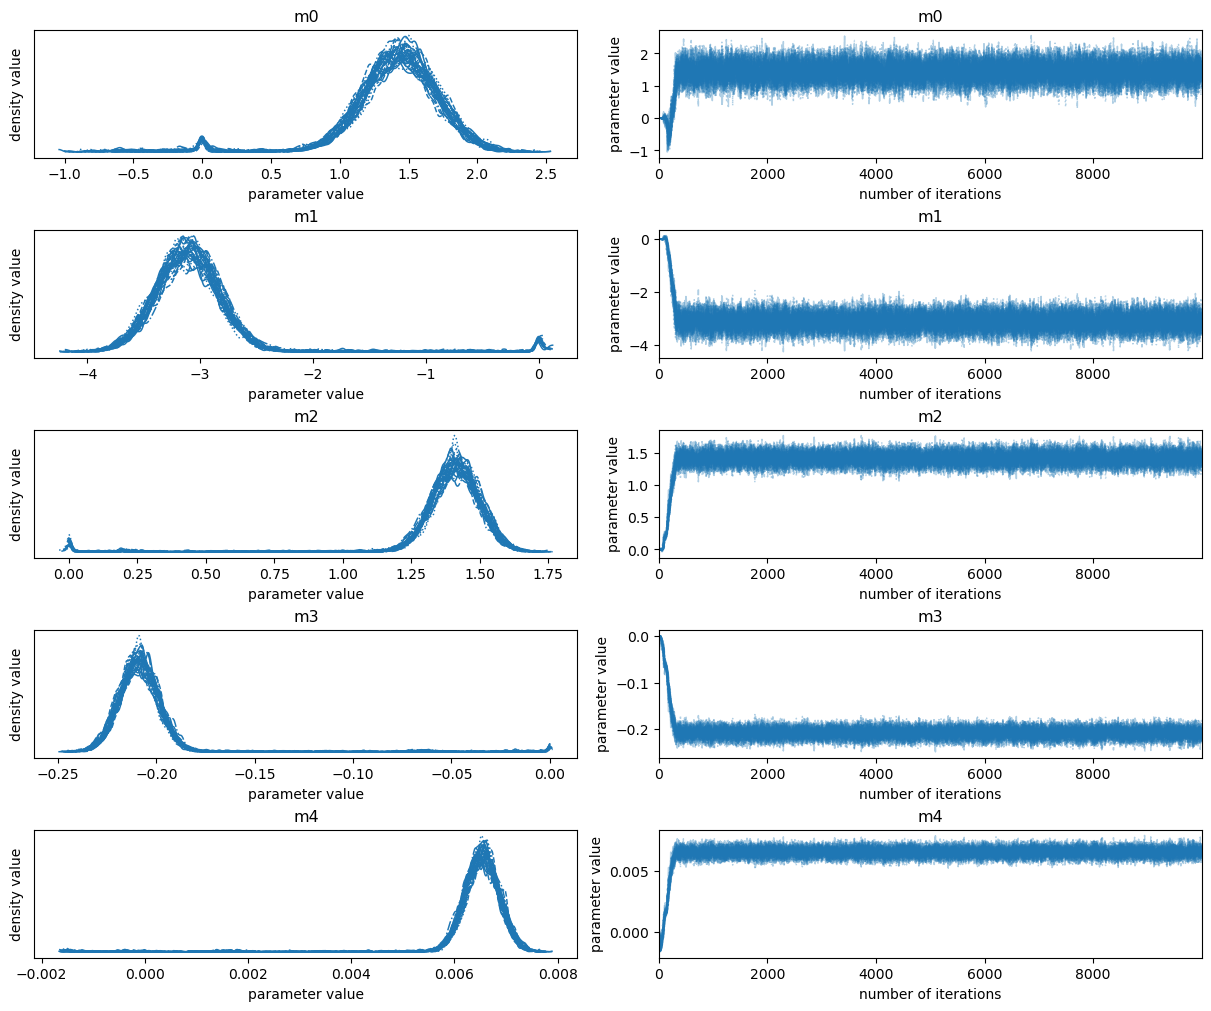

In [33]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True}); 

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    #ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [34]:
#tau = sampler.get_autocorr_time()
#print(f"autocorrelation time: {tau}")

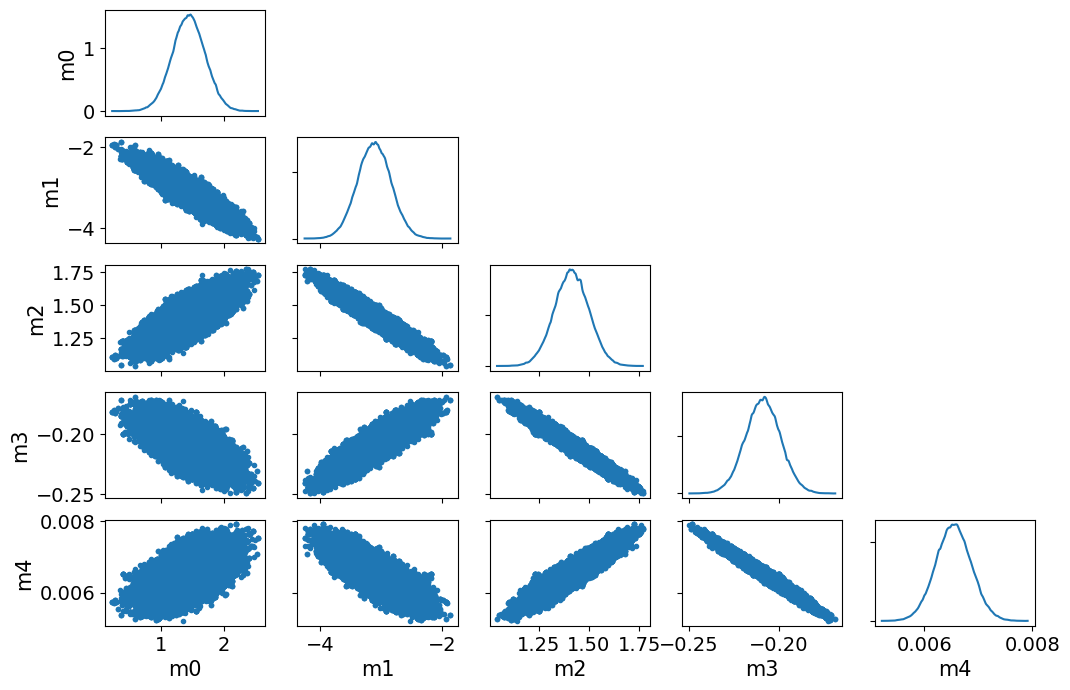

In [35]:
# a Corner plot

fig, axes = plt.subplots(nparams, nparams, figsize=(12,8))

if(True): # if we are plotting the model ensemble use this
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        ax=axes,
    );
else: # if we wish to plot a kernel density plot then use this option
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"},
        },
        ax=axes,
    );

Now we plot the predicted curves for the posterior ensemble of solutions.

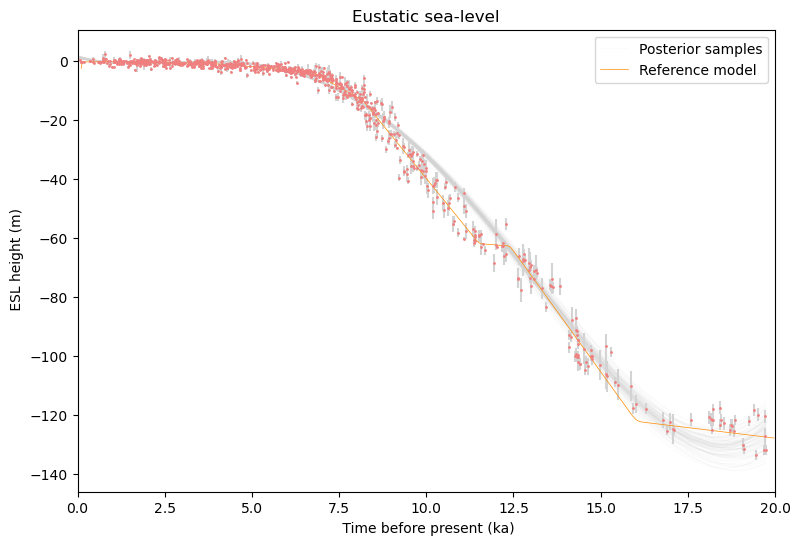

In [36]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data(title="Eustatic sea-level")
plt.xlim(0,maxtime)
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")
#plt.xlim(15,20.)
#plt.ylim(-140,-100)

#### Expected values, credible intervals and model covariance matrix from the ensemble

In [37]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0   1.438 [  1.009,   1.871]
 m1  -3.114 [ -3.560,  -2.673]
 m2   1.413 [  1.274,   1.553]
 m3  -0.209 [ -0.225,  -0.193]
 m4   0.007 [  0.006,   0.007]


In [38]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 6.79415794e-02 -6.30384030e-02  1.65853613e-02 -1.57522256e-03
   4.62362165e-05]
 [-6.30384030e-02  7.34760459e-02 -2.18693004e-02  2.25102543e-03
  -6.93416215e-05]
 [ 1.65853613e-02 -2.18693004e-02  7.18345301e-03 -7.94538016e-04
   2.55581172e-05]
 [-1.57522256e-03  2.25102543e-03 -7.94538016e-04  9.30574125e-05
  -3.10245008e-06]
 [ 4.62362165e-05 -6.93416215e-05  2.55581172e-05 -3.10245008e-06
   1.06365721e-07]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.2606
    m1  0.2711
    m2  0.0848
    m3  0.0096
    m4  0.0003


---------

### Challenge - Change the prior model bounds

Replace the previous prior bounds to new values

The original  uniform bounds had  

${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

Lets replace with

${\mathbf l}^T = (-0.5,-10.,-10.,-10.)$, and ${\mathbf u}^T = (0.5,10.,10.,10.)$.

We have only changed the bounds of the first parameter. However since the true value of constant term was 6, these bounds are now inconsistent with the true model.

What does this do to the posterior distribution?

Start from the code template below:

```
m_lower_bound = <CHANGE ME>             # lower bound for uniform prior
m_upper_bound = <CHANGE ME>             # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of <CHANGE ME>, upper bounds of <CHANGE ME>")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")
```

In [39]:
# Copy the template above, Replace <CHANGE ME> with your answer



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 135.40it/s]


Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]


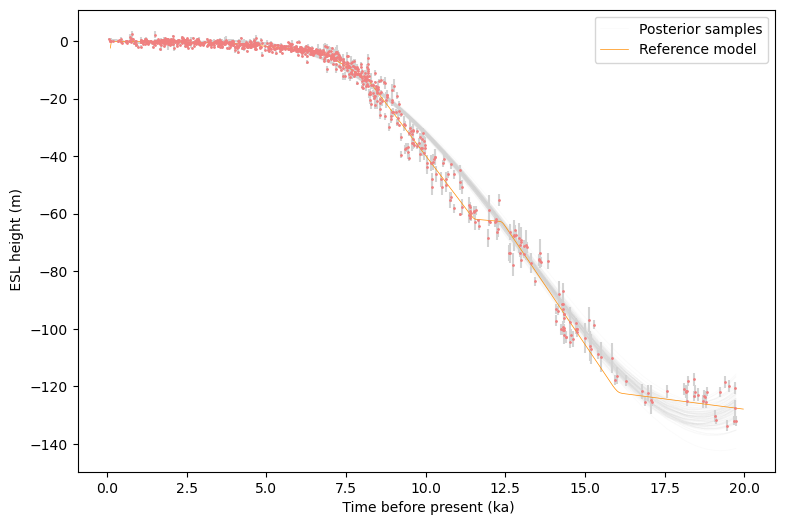

In [40]:
#@title Solution

m_lower_bound = np.array([-1.0,-10,-10,-10])             # lower bound for uniform prior
m_upper_bound = np.array([1.0,10,10,10])                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]")
plot_data()
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x, ref_y, "Reference model", color="darkorange")

Is there much change to the posterior distribution?

---

## Watermark

In [41]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev22
numpy 1.21.6
scipy 1.9.1
matplotlib 3.5.3
emcee 3.1.2
arviz 0.12.1
